In [2]:
'''Linear algebra'''
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

'''Data visualisation'''
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot # cf. 5.2

'''Preprocessing'''
from sklearn.impute import SimpleImputer # cf. 5.2
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler,LabelEncoder,OneHotEncoder # cf. 5.2

'''Deep learning'''
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences, TimeseriesGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.metrics import mean_squared_error

'''Pipeline'''
from sklearn.pipeline import Pipeline,FeatureUnion # cf. 5.6
from sklearn.compose import ColumnTransformer,make_column_selector # cf. 5.6
from sklearn.preprocessing import FunctionTransformer # cf. 5.6
from sklearn.base import TransformerMixin,BaseEstimator # cf. 5.6

# Loading dataset

In [3]:
dataset = pd.read_csv('../raw_data/ytrain_raw.csv')

/Users/nhuyghe/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1,3,5,11,20,49,52,54,55,56,64,70,71,94,95,101,102,114,129,131,132,133,138,139,152,157,163,174,180,184,193,196,201,207,208,219,220,228,241,245,250,256,258,264,265,269,270,271,272,273) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
dataset_cleaned = dataset.fillna('Down')
dataset_cleaned['timestamp'] = pd.to_datetime(dataset_cleaned['timestamp'])
dataset_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31232 entries, 0 to 31231
Columns: 274 entries, timestamp to S99-T2
dtypes: datetime64[ns, UTC](1), object(273)
memory usage: 65.3+ MB


In [5]:
dataset_cleaned = dataset.set_index('timestamp').fillna('Down')
dataset_cleaned = dataset_cleaned[:10000]

In [6]:
for col in dataset_cleaned.columns:
    dataset_cleaned[col] = dataset_cleaned[col].map({'Available':0, 'Charging':1, 'Down':0, 'Offline':0, 'Passive':0})

In [7]:
# Rename columns
borns_name = list(dataset_cleaned.columns)
stations_name = list(dataset_cleaned.columns.map(lambda x:x[:-3]))
cols_dict = {borns_name[i]: stations_name[i] for i in range(len(borns_name))}

df_stations = dataset_cleaned.rename(columns=cols_dict)

In [8]:
df_stations = df_stations.groupby(level=0,axis=1).sum()
df_stations.head()

,S1,S10,S11,S12,S13,S14,S15,S16,S17,S18,S19,S2,S20,S21,S22,S23,S24,S25,S26,S27,S28,S29,S3,S30,S31,S32,S33,S34,S35,S36,S37,S38,S39,S4,S41,S42,S45,S46,S47,S48,S49,S5,S50,S51,S52,S53,S56,S57,S58,S59,S6,S60,S62,S63,S64,S65,S66,S67,S68,S69,S7,S70,S71,S72,S74,S75,S76,S77,S78,S79,S8,S80,S81,S82,S83,S84,S85,S86,S87,S88,S89,S9,S91,S92,S93,S94,S95,S96,S97,S98,S99
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-11-25T00:00:00+00:00,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,3,0,1,0,0,0,2,0,0,0,0,0,2,0,0,1,0,0,0,0,0,1,1,0,0,0,0,2,0,0,0,2,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
2019-11-25T00:15:00+00:00,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,3,0,0,0,0,0,2,0,0,0,0,0,2,0,0,1,0,0,1,0,0,1,1,0,0,0,1,2,0,0,0,2,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2019-11-25T00:30:00+00:00,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,2,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2019-11-25T00:45:00+00:00,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,2,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2019-11-25T01:00:00+00:00,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,3,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,2,1,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [9]:
df_stations['all'] = df_stations.sum(axis=1)
df_stations.head()

,S1,S10,S11,S12,S13,S14,S15,S16,S17,S18,S19,S2,S20,S21,S22,S23,S24,S25,S26,S27,S28,S29,S3,S30,S31,S32,S33,S34,S35,S36,S37,S38,S39,S4,S41,S42,S45,S46,S47,S48,S49,S5,S50,S51,S52,S53,S56,S57,S58,S59,S6,S60,S62,S63,S64,S65,S66,S67,S68,S69,S7,S70,S71,S72,S74,S75,S76,S77,S78,S79,S8,S80,S81,S82,S83,S84,S85,S86,S87,S88,S89,S9,S91,S92,S93,S94,S95,S96,S97,S98,S99,all
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-11-25T00:00:00+00:00,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,3,0,1,0,0,0,2,0,0,0,0,0,2,0,0,1,0,0,0,0,0,1,1,0,0,0,0,2,0,0,0,2,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,27
2019-11-25T00:15:00+00:00,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,3,0,0,0,0,0,2,0,0,0,0,0,2,0,0,1,0,0,1,0,0,1,1,0,0,0,1,2,0,0,0,2,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,27
2019-11-25T00:30:00+00:00,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,2,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,21
2019-11-25T00:45:00+00:00,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,2,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,20
2019-11-25T01:00:00+00:00,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,3,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,2,1,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,24


In [10]:
df_stations = df_stations.reset_index()

# Creating new columns based on timestamp
df_stations['weekday'] = pd.to_datetime(df_stations['timestamp']).dt.weekday
df_stations['hour'] = pd.to_datetime(df_stations['timestamp']).dt.hour
df_stations['month'] = pd.to_datetime(df_stations['timestamp']).dt.month
df_stations['min'] = pd.to_datetime(df_stations['timestamp']).dt.minute

In [11]:
df_tmp = df_stations[['timestamp','all','weekday','hour','month','min']].set_index('timestamp')
df_tmp = df_tmp.rename(columns={'all':'nb_charging'})
df_tmp

,nb_charging,weekday,hour,month,min
timestamp,,,,,
2019-11-25T00:00:00+00:00,27,0,0,11,0
2019-11-25T00:15:00+00:00,27,0,0,11,15
2019-11-25T00:30:00+00:00,21,0,0,11,30
2019-11-25T00:45:00+00:00,20,0,0,11,45
2019-11-25T01:00:00+00:00,24,0,1,11,0
...,...,...,...,...,...
2020-03-08T16:45:00+00:00,17,6,16,3,45
2020-03-08T17:00:00+00:00,20,6,17,3,0
2020-03-08T17:15:00+00:00,22,6,17,3,15


# Preprocessing

In [12]:
train_size = int(len(df_tmp)*0.8)
val_size = int((len(df_tmp)-train_size)/2)
test_size = len(df_tmp)-train_size-val_size

df_train = df_tmp.iloc[0:train_size] 
df_val = df_tmp.iloc[train_size:train_size+val_size] 
df_test  = df_tmp.iloc[train_size+val_size:len(df_tmp)]

In [13]:
print("Length of df_train is", len(df_train))    
print("Length of df_val is", len(df_val)) 
print("Length of df_test set is",len(df_test))

Length of df_train is 8000
Length of df_val is 1000
Length of df_test set is 1000


# One step ahead

**This module is used to transform the dataset into sequence of timesteps**

In [14]:
def create_data_sequence(X, y, time_steps=1):
    """ Create data sequence  
    Arguments:
        * X: time-series data
        * y: Count "nb_charging" value
        * time_steps: Used to create input sequence of timesteps
    Returns:
        * input_sequence: Numpy array of sequences of time-series data
        * output: Numpy array of output i.e. next value for respective sequence
    """
    input_sequence = []
    output = []
    for i in range(len(X) - time_steps):
        sequence = X.iloc[i:(i + time_steps)].values
        input_sequence.append(sequence)        
        output.append(y.iloc[i + time_steps])
    return np.array(input_sequence), np.array(output)

## Baseline: Linear regression

In [ ]:
time_steps = 24*4 # 24 hours

# Baseline is only based on nb_charging as input and does not consider seasonality (e.g. weekday, hours, minute)
X_train_baseline, y_train_baseline = create_data_sequence(df_train.nb_charging, df_train.nb_charging, time_steps)
X_val_baseline, y_val_baseline = create_data_sequence(df_val.nb_charging, df_val.nb_charging, time_steps)
X_test_baseline, y_test_baseline = create_data_sequence(df_test.nb_charging, df_test.nb_charging, time_steps)

X_train_baseline = np.expand_dims(X_train_baseline, axis=-1)
X_val_baseline = np.expand_dims(X_val_baseline, axis=-1)
X_test_baseline = np.expand_dims(X_test_baseline, axis=-1)
y_train_baseline = np.expand_dims(y_train_baseline, axis=-1)
y_val_baseline = np.expand_dims(y_val_baseline, axis=-1)
y_test_baseline = np.expand_dims(y_test_baseline, axis=-1)

print("X_train_baseline shape", X_train_baseline.shape, "y_train_baseline shape", y_train_baseline.shape)
print("X_val_baseline shape", X_val_baseline.shape, "y_val_baseline shape", y_val_baseline.shape)
print("X_test_baseline shape", X_test_baseline.shape, "y_test_baseline shape", y_test_baseline.shape)

In [ ]:
model = Sequential()
model.add(layers.Flatten()),
model.add(layers.Dense(units=1, activation='linear'))

model.compile(loss="mse", 
              optimizer="adam",
              metrics=['mae'])

history = model.fit(X_train_baseline, 
                    y_train_baseline, 
                    epochs=20,
                    validation_data=(X_val_baseline, y_val_baseline))

In [15]:
def plot_loss_and_acc(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    # ax1.set_ylim(ymin=0, ymax=200)
    ax1.legend(['Train', 'Validation'], loc='best')
    
    ax2.plot(history.history['mae']) 
    ax2.plot(history.history['val_mae']) 
    ax2.set_title('MAE') 
    ax2.set_ylabel('MAE') 
    ax2.set_xlabel('Epoch')
    # ax2.set_ylim(ymin=0, ymax=20)
    ax2.legend(['Train', 'Validation'], loc='best')
    plt.show()

In [ ]:
plot_loss_and_acc(history)

In [ ]:
y_pred_baseline = model.predict(X_test_baseline)

In [16]:
def plot_series(X, y, y_pred):
    plt.plot(X, ".-")
    plt.plot(time_steps, y, "bx", markersize=10)
    plt.plot(time_steps, y_pred, "ro")
    plt.grid(True)
    plt.xlabel("$t$", fontsize=16, labelpad=5)
    plt.ylabel("$x(t)$", fontsize=16, labelpad=20, rotation=0)

In [ ]:
plot_series(X_test_baseline[-1, :, 0], y_test_baseline[-1, 0], y_pred_baseline[-1, 0])
plt.show()

## Basic LSTM model

In [ ]:
time_steps = 24*4 # 24 hours

X_train, y_train = create_data_sequence(df_train, df_train.nb_charging, time_steps)
X_val, y_val = create_data_sequence(df_val, df_val.nb_charging, time_steps)
X_test, y_test = create_data_sequence(df_test, df_test.nb_charging, time_steps)

# y_train needs to be in 3D
y_train = np.expand_dims(y_train, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

print("X_train shape", X_train.shape, "y_train shape", y_train.shape)
print("X_val shape", X_val.shape, "y_val shape", y_val.shape)
print("X_test shape", X_test.shape, "y_test shape", y_test.shape)

In [ ]:
def machine_learning_model():
    """Defines machine learning model
    Returns:
        * model: LSTM model
    """
    # Instantiate the model
    model = Sequential()
    
    # Define layers
    model.add(layers.LSTM(units=20,input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh', return_sequences=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LSTM(units=20, activation='tanh'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(units=1, activation='linear'))
    
    # Compilation
    model.compile(
        loss='mse', 
        optimizer='rmsprop',
        metrics=['mae'])
    
    return model

In [ ]:
model = machine_learning_model()

#### Define an EarlyStopping to prevent overfitting
es = EarlyStopping(patience=20,restore_best_weights=True)

history = model.fit(
    X_train,
    y_train, 
    epochs=20, 
    batch_size=32,
    validation_data=(X_val,y_val),
    callbacks=[es]
)

In [ ]:
plot_loss_and_acc(history)

## Deep RNN

In [17]:
time_steps = 24*4

X_train, y_train = create_data_sequence(df_train, df_train.nb_charging, time_steps)
X_val, y_val = create_data_sequence(df_val, df_val.nb_charging, time_steps)
X_test, y_test = create_data_sequence(df_test, df_test.nb_charging, time_steps)

# y_train needs to be in 3D
y_train = np.expand_dims(y_train, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

print("X_train shape", X_train.shape, "y_train shape", y_train.shape)
print("X_val shape", X_val.shape, "y_val shape", y_val.shape)
print("X_test shape", X_test.shape, "y_test shape", y_test.shape)

X_train shape (7904, 96, 5) y_train shape (7904, 1)
X_val shape (904, 96, 5) y_val shape (904, 1)
X_test shape (904, 96, 5) y_test shape (904, 1)


In [18]:
def machine_learning_model_2():
    """Defines machine learning model
    Returns:
        * model: LSTM model
    """
    # Instantiate the model
    model = Sequential()
    
    # Define layers
    model.add(layers.LSTM(units=20,input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh', return_sequences=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LSTM(units=20, activation='tanh'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(units=1, activation='linear'))
    
    # Compilation
    model.compile(
        loss='mse', 
        optimizer='rmsprop',
        metrics=['mae'])
    
    return model

In [19]:
model = machine_learning_model_2()

#### Define an EarlyStopping to prevent overfitting
es = EarlyStopping(patience=20,restore_best_weights=True)

history = model.fit(
    X_train,
    y_train, 
    epochs=20, 
    batch_size=32,
    validation_data=(X_val,y_val),
    callbacks=[es]
)

Epoch 1/20
247/247 [==============================] - 38s 118ms/step - loss: 389.8866 - mae: 18.5013 - val_loss: 262.6831 - val_mae: 15.4632
Epoch 2/20
247/247 [==============================] - 23s 92ms/step - loss: 253.8296 - mae: 15.3329 - val_loss: 153.5959 - val_mae: 12.0096
Epoch 3/20
247/247 [==============================] - 25s 100ms/step - loss: 113.0659 - mae: 9.7091 - val_loss: 22.0146 - val_mae: 3.9650
Epoch 4/20
247/247 [==============================] - 23s 92ms/step - loss: 30.4994 - mae: 4.3383 - val_loss: 8.6887 - val_mae: 2.3062
Epoch 5/20
247/247 [==============================] - 26s 103ms/step - loss: 22.4563 - mae: 3.6822 - val_loss: 8.7712 - val_mae: 2.2948
Epoch 6/20
247/247 [==============================] - 21s 87ms/step - loss: 20.5253 - mae: 3.5217 - val_loss: 8.1197 - val_mae: 2.2236
Epoch 7/20
247/247 [==============================] - 23s 93ms/step - loss: 19.9726 - mae: 3.4307 - val_loss: 7.9051 - val_mae: 2.1789
Epoch 8/20
247/247 [====================

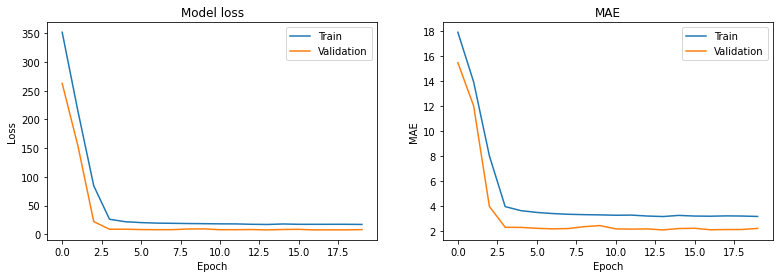

In [20]:
plot_loss_and_acc(history)

In [21]:
y_pred = model.predict(X_test)

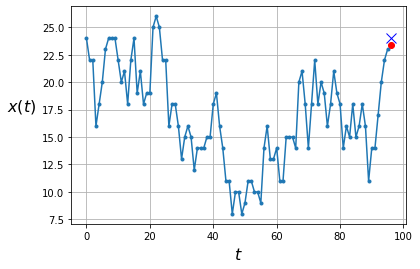

In [22]:
plot_series(X_test[-1, :, 0], y_test[-1, 0], y_pred[-1, 0])
plt.show()

# Multi-steps

In [23]:
def create_data_seq2vec(X, y, time_steps=1, horizon=1):
    """ Create data sequence  
    Arguments:
        * X: time-series data
        * y: Count "nb_charging" value
        * time_steps: Used to create input sequence of timesteps
    Returns:
        * input_sequence: Numpy array of sequences of time-series data
        * output: Numpy array of output i.e. next value for respective sequence
    """
    input_sequence = []
    output_sequence = []
    for i in range(len(X) - time_steps - horizon):
        sequence = X.iloc[i:(i + time_steps)].values
        input_sequence.append(sequence)  
        output_sequence.append(y.iloc[i + time_steps:i + time_steps + horizon])
    return np.array(input_sequence), np.array(output_sequence)

## Linear regression

In [24]:
time_steps = 24*4
horizon = 12

X_train_baseline, Y_train_baseline = create_data_seq2vec(df_train.nb_charging, df_train.nb_charging, time_steps, horizon)
X_val_baseline, Y_val_baseline = create_data_seq2vec(df_val.nb_charging, df_val.nb_charging, time_steps, horizon)
X_test_baseline, Y_test_baseline = create_data_seq2vec(df_test.nb_charging, df_test.nb_charging, time_steps, horizon)

print("X_train_baseline shape", X_train_baseline.shape, "Y_train_baseline shape", Y_train_baseline.shape)
print("X_val_baseline shape", X_val_baseline.shape, "Y_val_baseline shape", Y_val_baseline.shape)
print("X_test_baseline shape", X_test_baseline.shape, "Y_test_baseline shape", Y_test_baseline.shape)

X_train_baseline shape (7892, 96) Y_train_baseline shape (7892, 12)
X_val_baseline shape (892, 96) Y_val_baseline shape (892, 12)
X_test_baseline shape (892, 96) Y_test_baseline shape (892, 12)


In [25]:
model = Sequential()
model.add(layers.Flatten()),
model.add(layers.Dense(units=horizon, activation='linear'))

model.compile(loss="mse", 
              optimizer="adam",
              metrics=['mae'])

history = model.fit(X_train_baseline, 
                    Y_train_baseline, 
                    epochs=20,
                    validation_data=(X_val_baseline, Y_val_baseline))

Epoch 1/20
247/247 [==============================] - 2s 4ms/step - loss: 480.4155 - mae: 14.1255 - val_loss: 51.0088 - val_mae: 5.6775
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 69.5904 - mae: 6.4372 - val_loss: 42.0855 - val_mae: 5.1324
Epoch 3/20
247/247 [==============================] - 1s 4ms/step - loss: 58.1863 - mae: 5.8099 - val_loss: 38.9143 - val_mae: 4.9033
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 51.9511 - mae: 5.4537 - val_loss: 36.1440 - val_mae: 4.7291
Epoch 5/20
247/247 [==============================] - 1s 4ms/step - loss: 50.1420 - mae: 5.3121 - val_loss: 35.4860 - val_mae: 4.6589
Epoch 6/20
247/247 [==============================] - 1s 5ms/step - loss: 49.5326 - mae: 5.3049 - val_loss: 33.6755 - val_mae: 4.5404
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 46.9885 - mae: 5.1228 - val_loss: 32.7940 - val_mae: 4.4763
Epoch 8/20
247/247 [==============================] - 1s 4ms

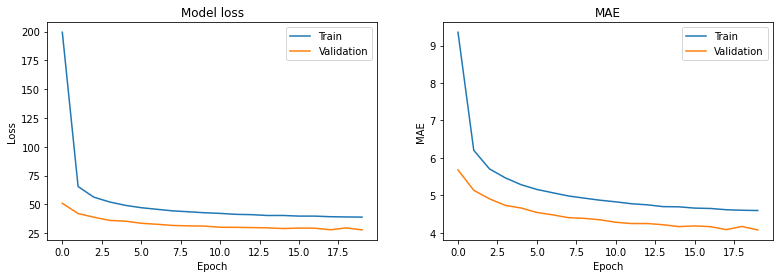

In [26]:
plot_loss_and_acc(history)

In [45]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plt.plot(X[-1, :,0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[-1, :], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[-1, :], "bx-", label="Forecast", markersize=10)
    #plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

In [46]:
Y_pred_baseline = model.predict(X_test_baseline)

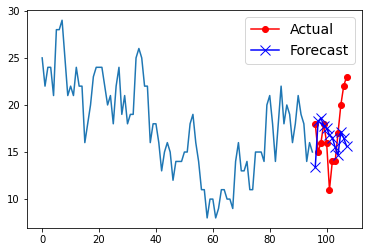

In [48]:
plot_multiple_forecasts(np.expand_dims(X_test_baseline,axis=-1), Y_test_baseline, Y_pred_baseline)

## Deep RNN

In [51]:
time_steps = 24*4
horizon = 12

X_train, Y_train = create_data_seq2vec(df_train, df_train.nb_charging, time_steps, horizon)
X_val, Y_val = create_data_seq2vec(df_val, df_val.nb_charging, time_steps, horizon)
X_test, Y_test = create_data_seq2vec(df_test, df_test.nb_charging, time_steps, horizon)

print("X_train shape", X_train.shape, "Y_train shape", Y_train.shape)
print("X_val shape", X_val.shape, "Y_val shape", Y_val.shape)
print("X_test shape", X_test.shape, "Y_test shape", Y_test.shape)

X_train shape (7892, 96, 5) Y_train shape (7892, 12)
X_val shape (892, 96, 5) Y_val shape (892, 12)
X_test shape (892, 96, 5) Y_test shape (892, 12)


In [58]:
def machine_learning_model_3():
    """Defines machine learning model
    Returns:
        * model: LSTM model
    """
    # Instantiate the model
    model = Sequential()
    
    # Define layers
    model.add(layers.LSTM(units=128,input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh', return_sequences=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LSTM(units=64, activation='tanh'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(units=horizon, activation='linear'))
    
    # Compilation
    model.compile(
        loss='mse', 
        optimizer='rmsprop',
        metrics = ['mae'])
    
    return model

In [59]:
model = machine_learning_model_3()

#### Define an EarlyStopping to prevent overfitting
es = EarlyStopping(patience=20,restore_best_weights=True)

history = model.fit(
    X_train,
    Y_train, 
    epochs=20, 
    batch_size=32,
    validation_data=(X_val,Y_val),
    callbacks=[es]
)

Epoch 1/20
247/247 [==============================] - 70s 254ms/step - loss: 390.4725 - mae: 18.4729 - val_loss: 264.2835 - val_mae: 15.2784
Epoch 2/20
247/247 [==============================] - 61s 248ms/step - loss: 179.8352 - mae: 12.1086 - val_loss: 34.4838 - val_mae: 4.6902
Epoch 3/20
247/247 [==============================] - 61s 246ms/step - loss: 35.0887 - mae: 4.4437 - val_loss: 29.4898 - val_mae: 4.0740
Epoch 4/20
247/247 [==============================] - 60s 241ms/step - loss: 29.4309 - mae: 4.0438 - val_loss: 29.2098 - val_mae: 4.0148
Epoch 5/20
247/247 [==============================] - 60s 242ms/step - loss: 28.2299 - mae: 3.9492 - val_loss: 29.7184 - val_mae: 4.0789
Epoch 6/20
247/247 [==============================] - 62s 249ms/step - loss: 26.2782 - mae: 3.7975 - val_loss: 38.8936 - val_mae: 4.5980
Epoch 7/20
247/247 [==============================] - 74s 298ms/step - loss: 25.3515 - mae: 3.7602 - val_loss: 29.5565 - val_mae: 3.8676
Epoch 8/20
247/247 [===============

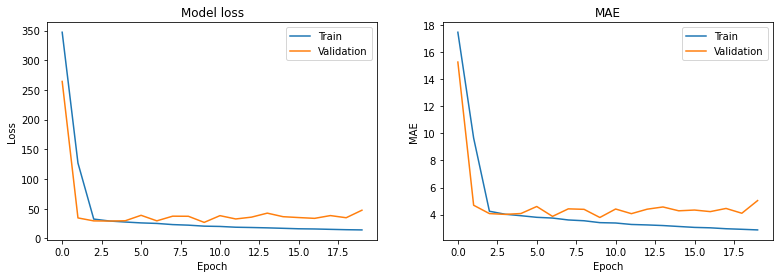

In [60]:
plot_loss_and_acc(history)

In [61]:
Y_pred = model.predict(X_test)

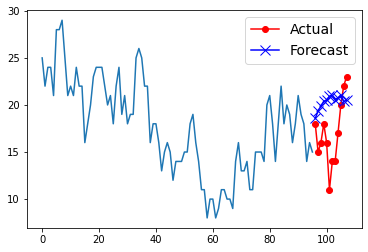

In [62]:
plot_multiple_forecasts(X_test, Y_test, Y_pred)
plt.show()